# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [33]:
data = pd.read_csv('D:\Irina\Data Science\ML\Практика\data\_bank_fin.csv', sep = ';')
df=data.copy()
df.head() 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


В Дата сэте 6 числовых признаков и 10 категориальных. Имеются пропуски по столбцу "balance"

### Задание 2

Определим, каким словом закодированы отсутсвуюшие признаки

In [35]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

In [36]:
df['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

Это слово "unknown"

### Задание 3

Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [37]:
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(' ','')
df['balance'] = df['balance'].str.replace(',00','')
df.head()
df['balance'] = df['balance'].astype(float)

In [38]:
df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [39]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [40]:
# обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку
df.fillna(df['balance'].median(), inplace = True)


In [41]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [42]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)

In [43]:
round(df[(df['education']=='secondary') & (df['job']=='management')]['balance'].mean(),3)

1598.883

### Задание 6

In [44]:
# удалим все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Нижняя граница: {lower_bound}')
print(f'Нижняя граница: {upper_bound}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница: -2241.0
Нижняя граница: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

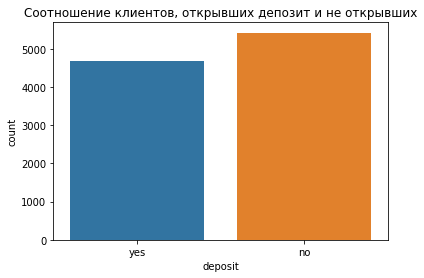

no     5424
yes    4681
Name: deposit, dtype: int64


In [14]:
# изучим соотношение классов в данных на предмет несбалансированности, проиллюстрируем результат
pl = sns.countplot(x=cleaned["deposit"])
pl.set_title("Соотношение клиентов, открывших депозит и не открывших")
plt.show()
print(cleaned["deposit"].value_counts())

### Задания 2 и 3

In [15]:
#рассчитаем описательные статистики для количественных переменных, проинтерпретируем результат
#numeric_cleaned = cleaned['age', 'day', 'duration', 'campaign', 'pdays', 'previous', 'balance']
#numeric_cleaned.describe()
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [16]:
#рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат
kategorial_cleaned = cleaned[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome','deposit']]
kategorial_cleaned.describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


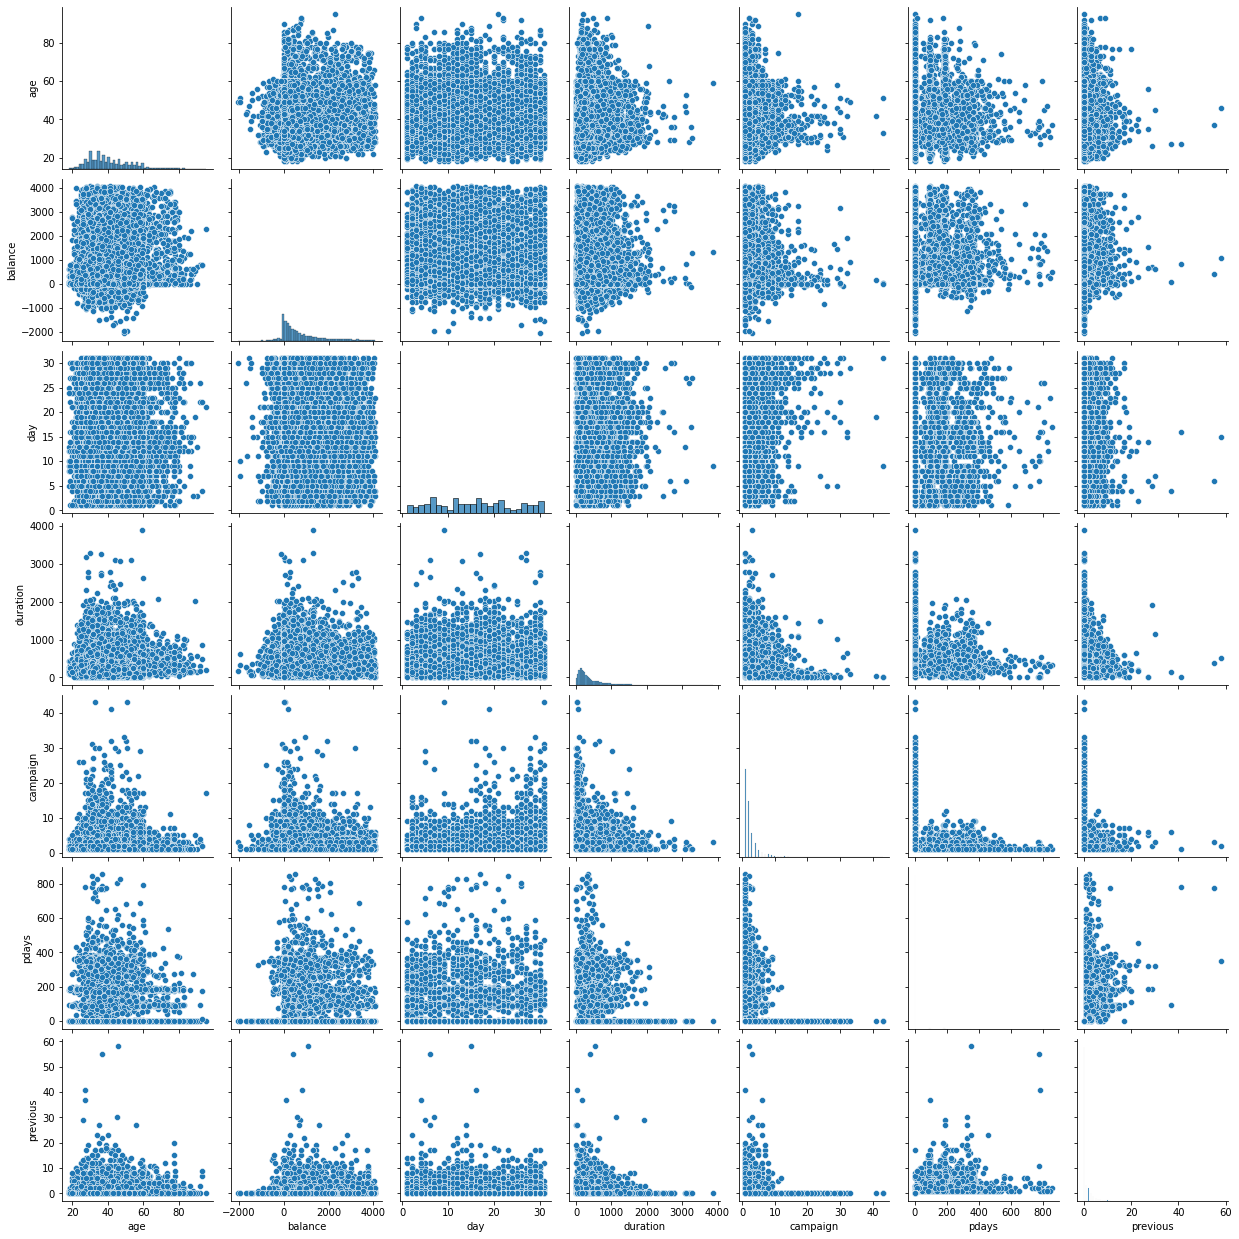

In [17]:
sns.pairplot(cleaned)

### Задание 6

<AxesSubplot: xlabel='poutcome'>

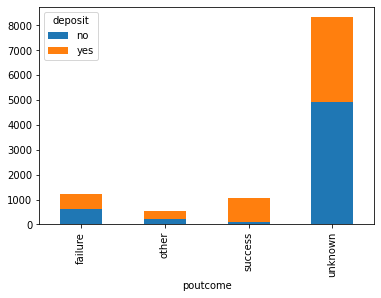

In [18]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

Этот статус "success"

### Задание 7

In [378]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
cleaned['percent_succes']=cleaned['deposit_yes']/(cleaned['deposit_yes']+cleaned['deposit_no'])*100
cleaned['percent_failure']=cleaned['deposit_no']/(cleaned['deposit_yes']+cleaned['deposit_no'])*100
df_pivot=pd.pivot_table(cleaned[['month', 'percent_succes', 'percent_failure']], index='month', aggfunc='mean')
df_pivot

,percent_failure,percent_succes
month,,
apr,38.192771,61.807229
aug,55.956679,44.043321
dec,9.677419,90.322581
feb,45.557123,54.442877
jan,60.815047,39.184953
jul,58.956276,41.043724
jun,54.891304,45.108696
mar,10.126582,89.873418
may,67.863966,32.136034


Самый непопулярный месяц для открытия депозита май

### Задание 8

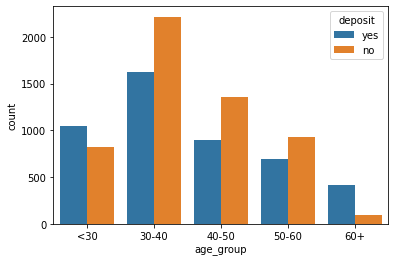

In [46]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_group'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned);

### Задания 9 и 10

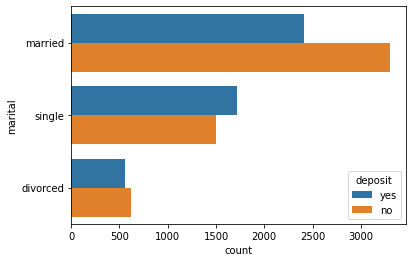

In [47]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=cleaned);

Одинокие люди чаще принимают решение открыть депозит, чем отказываются от него, но при это больший объем открытых депозитов у пар.

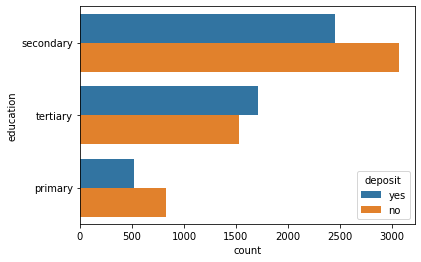

In [48]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=cleaned);

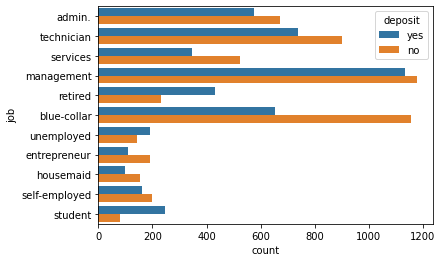

In [49]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=cleaned);


### Задание 11

In [380]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
grouped_table_yes=pd.crosstab(index=cleaned['marital'], columns=cleaned['education'], values=cleaned['deposit_yes'], aggfunc=sum)
grouped_table_no=pd.crosstab(index=cleaned['marital'], columns=cleaned['education'], values=cleaned['deposit_no'], aggfunc=sum)
print(grouped_table_yes)
print(grouped_table_no)

education  primary  secondary  tertiary
marital                                
divorced        96        283       174
married        339       1289       784
single          82        879       755
education  primary  secondary  tertiary
marital                                
divorced        91        370       163
married        641       1830       832
single         100        866       531


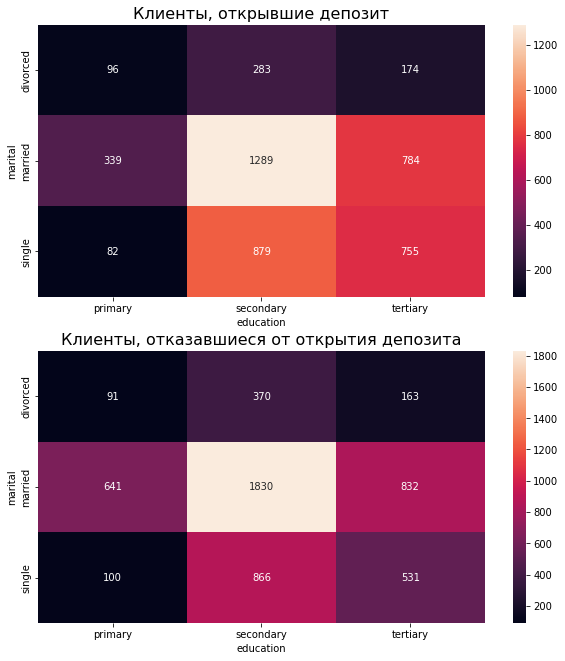

In [291]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 11))
heatmap = sns.heatmap(data=grouped_table_yes, annot=True, fmt=".0f", ax=axes[0]);
axes[0].set_title('Клиенты, открывшие депозит', fontsize=16);
heatmap = sns.heatmap(data=grouped_table_no, annot=True, fmt=".0f", ax=axes[1]);
axes[1].set_title('Клиенты, отказавшиеся от открытия депозита', fontsize=16);

Таким образом саммая многочисленная группа женатых с образованием secondary.

## Часть 3: преобразование данных

### Задание 1

In [50]:
# преобразуем уровни образования
le = preprocessing.LabelEncoder()
cleaned['education']=le.fit_transform(cleaned['education'])
cleaned['education'].sum()

11995

In [51]:
# преобразуем возрастные группы
le = preprocessing.LabelEncoder()
cleaned['age_group']=le.fit_transform(cleaned['age_group'])
cleaned['age_group'].sum()

14524

### Задания 2 и 3

In [52]:
# преобразуем бинарные переменные в представление из нулей и единиц
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['deposit'].std()

0.4986712532452124

In [53]:
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['default'].mean()+cleaned['housing'].mean()+cleaned['loan'].mean()

0.6354280059376547

In [54]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int32  
 4   default    10105 non-null  int64  
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  int64  
 7   loan       10105 non-null  int64  
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  int64  
 17  age_group  10105 non-null  int32  
dtypes: float64(1), int32(2), int64(10), object(5)
memory usage: 1.4+ MB


### Задание 4

In [70]:
# создадим дамми-переменные
dummies_data = pd.get_dummies(cleaned)
dummies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

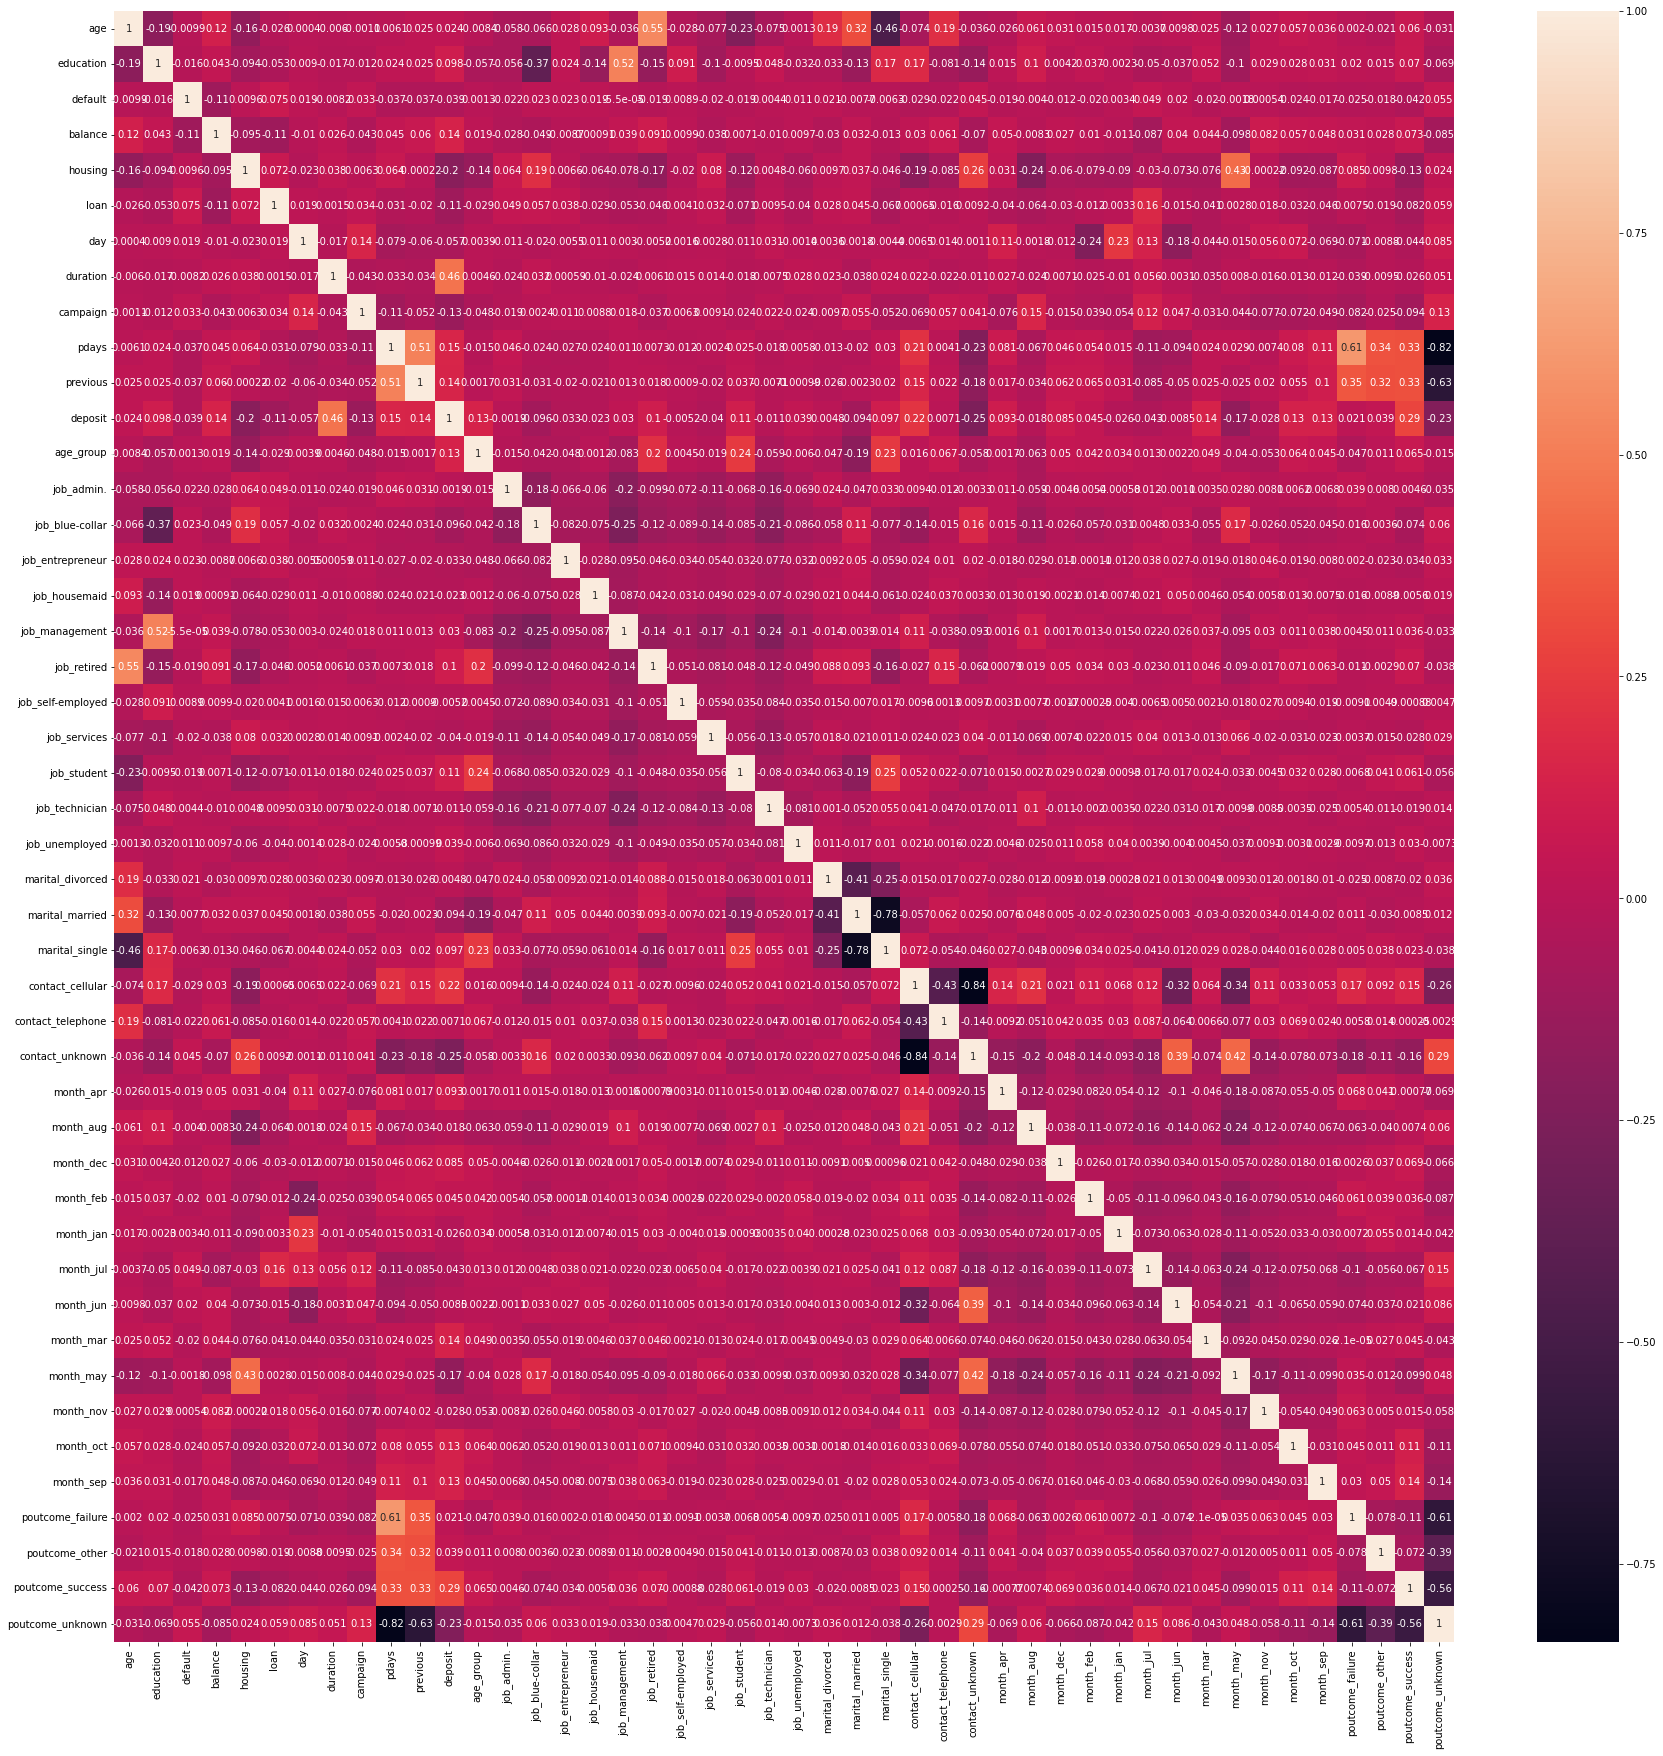

In [56]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (30, 30))
sns.heatmap(dummies_data.corr(), annot = True);

### Задания 7 и 8

In [62]:
X = dummies_data.drop(['deposit'], axis=1)
y = dummies_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [58]:
X_test.shape

(3335, 45)

In [59]:
y_test.mean()

0.46326836581709147

### Задание 9

In [66]:
# с помощью SelectKBest отберем 15 наиболее подходящих признаков
select_reg =  SelectKBest(k=15, score_func=f_classif)
select_reg.fit(X_train, y_train)
X_train_new = select_reg.transform(X_train)
new_df = X_train.iloc[:,select_reg.get_support()]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 7287 to 4966
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   balance           6770 non-null   float64
 1   housing           6770 non-null   int64  
 2   duration          6770 non-null   int64  
 3   campaign          6770 non-null   int64  
 4   pdays             6770 non-null   int64  
 5   previous          6770 non-null   int64  
 6   age_group         6770 non-null   int32  
 7   contact_cellular  6770 non-null   uint8  
 8   contact_unknown   6770 non-null   uint8  
 9   month_mar         6770 non-null   uint8  
 10  month_may         6770 non-null   uint8  
 11  month_oct         6770 non-null   uint8  
 12  month_sep         6770 non-null   uint8  
 13  poutcome_success  6770 non-null   uint8  
 14  poutcome_unknown  6770 non-null   uint8  
dtypes: float64(1), int32(1), int64(5), uint8(8)
memory usage: 449.6 KB


### Задание 10

In [71]:
#Создадим датасэт с выбранными признаками
new_df2=dummies_data[['balance', 'housing', 'duration', 'campaign', 'pdays', 
                     'previous', 'age_group', 'contact_cellular', 'contact_unknown', 
                     'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 
                     'poutcome_unknown', 'deposit']]
new_df2.head()

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown,deposit
0,2343.0,1,1042,1,-1,0,2,0,1,0,1,0,0,0,1,1
1,45.0,0,1467,1,-1,0,2,0,1,0,1,0,0,0,1,1
2,1270.0,1,1389,1,-1,0,1,0,1,0,1,0,0,0,1,1
3,2476.0,1,579,1,-1,0,2,0,1,0,1,0,0,0,1,1
4,184.0,0,673,2,-1,0,2,0,1,0,1,0,0,0,1,1


In [74]:
X = new_df2.drop(['deposit'], axis=1)
y = new_df2['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [75]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled[:, 0].mean())

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [79]:
# обучим логистическую регрессию и рассчитаем метрики качества
log_reg = linear_model.LogisticRegression(solver='sag',
                                          random_state=42, 
                                          max_iter=1000)

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print('Accuracy для тренировочной выборки: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy для тестовой выборки: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy для тренировочной выборки: 0.82
Accuracy для тестовой выборки: 0.81


### Задания 2,3,4

In [91]:
# обучим решающие деревья, настроив максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

print('Accuracy для тренировочной выборки: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy для тестовой выборки: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy для тренировочной выборки: 0.82
Accuracy для тестовой выборки: 0.81


Получили метрики, как у логистической регрессии.

### Задание 5

In [93]:
# подберем оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(model_cv.score(X_test_scaled, y_test)))
y_test_pred = model_cv.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))



accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [98]:
# обучим на данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test_scaled, y_test)))
y_test_pred = rf.predict(X_test_scaled)
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.83
recall на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


Метрики улучшились

### Задания 2 и 3

In [99]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(gb.score(X_test_scaled, y_test)))
y_test_pred = gb.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


Метрики не изменились

### Задание 4

In [100]:
# объединим алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(gb.score(X_test_scaled, y_test)))
y_test_pred = gb.predict(X_test_scaled)
print(' precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
 precision на тестовом наборе: 0.80


Метрики не изменились

### Задания 6,7,8

In [107]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-04-09 18:20:55,499] A new study created in memory with name: RandomForestClassifier
[I 2023-04-09 18:20:56,449] Trial 0 finished with value: 0.8934707903780069 and parameters: {'n_estimators': 167, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8934707903780069.
[I 2023-04-09 18:20:57,086] Trial 1 finished with value: 0.853932584269663 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8934707903780069.
[I 2023-04-09 18:20:58,108] Trial 2 finished with value: 0.8618318224445138 and parameters: {'n_estimators': 195, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8934707903780069.
[I 2023-04-09 18:20:59,058] Trial 3 finished with value: 0.8841577958672511 and parameters: {'n_estimators': 161, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8934707903780069.
[I 2023-04-09 18:20:59,618] Trial 4 finished with value: 0.8778733385457389 and parameters: {'n_e

Наилучшие значения гиперпараметров {'n_estimators': 146, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


Метрики не изменились